本章では，Bo Pang氏とLillian Lee氏が公開しているMovie Review Dataのsentence polarity dataset v1.0を用い，文を肯定的（ポジティブ）もしくは否定的（ネガティブ）に分類するタスク（極性分析）に取り組む．

In [1]:
%%bash 
wget http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.README.1.0.txt

--2018-05-04 11:02:49--  http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.README.1.0.txt
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.20
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1682 (1.6K) [text/plain]
Saving to: ‘rt-polaritydata.README.1.0.txt’

     0K .                                                     100%  112M=0s

2018-05-04 11:02:50 (112 MB/s) - ‘rt-polaritydata.README.1.0.txt’ saved [1682/1682]



In [2]:
%%bash
wget http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz

--2018-05-04 11:03:12--  http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.20
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 487770 (476K) [application/x-gzip]
Saving to: ‘rt-polaritydata.tar.gz’

     0K .......... .......... .......... .......... .......... 10%  132K 3s
    50K .......... .......... .......... .......... .......... 20%  128K 3s
   100K .......... .......... .......... .......... .......... 31% 7.86M 2s
   150K .......... .......... .......... .......... .......... 41%  276K 1s
   200K .......... .......... .......... .......... .......... 52%  127K 1s
   250K .......... .......... .......... .......... .......... 62%  131K 1s
   300K .......... .......... .......... .......... .......... 73%  287K 1s
   350K .......... .......... .......... .......... .......... 83%  120K 0s
   400

In [5]:
%%bash
tar -zxvf rt-polaritydata.tar.gz

rt-polaritydata.README.1.0.txt
rt-polaritydata/rt-polarity.neg
rt-polaritydata/rt-polarity.pos


## 70. データの入手・整形
文に関する極性分析の正解データを用い，以下の要領で正解データ（sentiment.txt）を作成せよ．

rt-polarity.posの各行の先頭に"+1 "という文字列を追加する（極性ラベル"+1"とスペースに続けて肯定的な文の内容が続く）
rt-polarity.negの各行の先頭に"-1 "という文字列を追加する（極性ラベル"-1"とスペースに続けて否定的な文の内容が続く）
上述1と2の内容を結合（concatenate）し，行をランダムに並び替える
sentiment.txtを作成したら，正例（肯定的な文）の数と負例（否定的な文）の数を確認せよ．

In [2]:
import random
pos = []
neg = []
with open("rt-polaritydata/rt-polarity.neg",encoding="cp1252") as f_neg, open("rt-polaritydata/rt-polarity.pos",encoding="cp1252") as f_pos:
    pos.extend(["+1 " + l_pos for l_pos in f_pos])
    neg.extend(["-1 " + l_neg for l_neg in f_neg])
train = pos + neg
random.shuffle(train)
with open("sentiment.txt","w") as g:
    g.writelines(train)

pos_n = 0
neg_n = 0
with open("sentiment.txt","r") as f:
    for line in f:
        if line[:2] == "+1":
            pos_n += 1
        elif line[:2] == "-1":
            neg_n += 1
        else:
            print("ERROR: {} is no pos and neg".format(line[:-1]))
            raise
print("pos",pos_n)
print("neg",neg_n)

pos 5331
neg 5331


## 71. ストップワード
英語のストップワードのリスト（ストップリスト）を適当に作成せよ．さらに，引数に与えられた単語（文字列）がストップリストに含まれている場合は真，それ以外は偽を返す関数を実装せよ．さらに，その関数に対するテストを記述せよ．

In [3]:
from collections import defaultdict
# 上位100 ヒューリスティックで削除も可能
def make_stopword(data):
    voc_dic = defaultdict(int)
    for line in data:
        for word in line.split()[1:-1]:
            voc_dic[word] += 1
    return [ k for k,v in  sorted(voc_dic.items(),key=lambda x:x[1],reverse=True)[:100] ]
    
stopwords = make_stopword(train)

def check_stopwords(word):
    return  word in stopwords

print(check_stopwords("a"))
print(check_stopwords("swift"))

True
False


In [54]:
train[0]

'+1  . . . is funny in the way that makes you ache with sadness ( the way chekhov is funny ) , profound without ever being self-important , warm without ever succumbing to sentimentality . \n'

## 72. 素性抽出
極性分析に有用そうな素性を各自で設計し，学習データから素性を抽出せよ．素性としては，レビューからストップワードを除去し，各単語をステミング処理したものが最低限のベースラインとなるであろう．

1. remove stop words
1. steming
1. normalize


In [42]:
from nltk import stem
def select_characted_words(pos,neg):
    voc_dic = defaultdict(int)
    for line in pos:
        for word in line.split()[1:-1]:
            voc_dic[ stem.porter.PorterStemmer().stem(word)] += 1
    for line in neg:
        for word in line.split()[1:-1]:
            voc_dic[ stem.porter.PorterStemmer().stem(word)] -= 1
    return [ k for k,v in sorted(voc_dic.items(),key=lambda x:x[1],reverse=True) if (v >= 8 or  v <= -8) and not k in stopwords and len(k) >= 3]
char_words = select_characted_words(pos,neg)
len(char_words)

961

## 73. 学習
72で抽出した素性を用いて，ロジスティック回帰モデルを学習せよ．

In [45]:
import numpy as np
def char2dic(char_words):
    return { char:i for i,char in enumerate(char_words) }
def dic2char(char_words):
    return {i:char for i,char in enumerate(char_words)}

def make_data(data):
    char_dic = char2dic(char_words)
    dic_char = dic2char(char_words)
    inputs = np.zeros([len(data), len(char_dic)])
    outputs = np.zeros([len(data)])
    for i,line in enumerate(data):
        for word in line[:-1].split()[1:]:
            if stem.porter.PorterStemmer().stem(word) in char_dic:
                inputs[i][char_dic[stem.porter.PorterStemmer().stem(word)]] += 1
        outputs[i] = int(line[:-1].split()[0])
    return inputs,outputs

inputs,outputs = make_data(train)
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(inputs,outputs)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## 74. 予測
73で学習したロジスティック回帰モデルを用い，与えられた文の極性ラベル（正例なら"+1"，負例なら"-1"）と，その予測確率を計算するプログラムを実装せよ．

In [32]:
pred = lr.predict(inputs)
pred[:10]

array([-1., -1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.])

## 75. 素性の重み
73で学習したロジスティック回帰モデルの中で，重みの高い素性トップ10と，重みの低い素性トップ10を確認せよ

In [68]:
params = lr.coef_.reshape(-1)
bottom =  params.argsort()[:10]
top = params.argsort()[-10:]
dic_char = dic2char(char_words)
print("top",[ dic_char[i] for i in top ])
print("bottom",[ dic_char[i] for i in bottom])

top ['grandeur', 'polish', 'examin', 'reflect', 'awar', 'sli', 'resist', 'unexpect', 'refresh', 'engross']
bottom ['bore', 'dull', 'plod', 'wast', 'badli', 'appar', 'flat', 'unfunni', 'neither', 'squander']


## 76. ラベル付け
学習データに対してロジスティック回帰モデルを適用し，正解のラベル，予測されたラベル，予測確率をタブ区切り形式で出力せよ．

In [72]:
out = "76Logresult.txt"
pred = lr.predict(inputs)
prob = lr.predict_proba(inputs)
with open(out,"w") as f:
    f.write("ans\tpred\tprob\n")
    for ans,pd,pb in zip(outputs,pred,prob):
        f.write("{}\t{}\t{}\n".format(ans,pd,pb))

In [73]:
%%bash
head 76Logresult.txt

ans	pred	prob
-1.0	-1.0	[ 0.99597134  0.00402866]
-1.0	-1.0	[ 0.79211232  0.20788768]
-1.0	-1.0	[ 0.62983798  0.37016202]
-1.0	-1.0	[ 0.8590184  0.1409816]
-1.0	-1.0	[ 0.97469768  0.02530232]
1.0	1.0	[ 0.20532811  0.79467189]
1.0	-1.0	[ 0.66038899  0.33961101]
1.0	1.0	[ 0.03701433  0.96298567]
1.0	1.0	[ 0.0155183  0.9844817]


## 77. 正解率の計測
76の出力を受け取り，予測の正解率，正例に関する適合率，再現率，F1スコアを求めるプログラムを作成せよ．

In [80]:
def confusion_matrix(ans,pred):
    tp,tn,fp,fn = 0,0,0,0
    for an,pd in zip(ans,pred):
        if an == pd and an > 0:
            tp += 1
        elif an == pd:
            tn += 1
        elif an > 0:
            fn += 1
        else:
            fp += 1
    return tp,tn,fp,fn

def acprecl(outputs,pred):
    tp,tn,fp,fn = confusion_matrix(outputs,pred)
    accuracy = (tp + tn ) / ( tp + tn + fp + fn) * 100
    precision = tp / (tp + fp) * 100
    recall = tp / (tp + fn ) * 100
    f1 =  2 * tp /( 2 * tp + fp + fn) * 100
    return accuracy,precision,recall,f1

accuracy,precision,recall,f1 = acprecl(outputs,pred)
print("accuracy",accuracy)
print("precison",precision)
print("recall",recall)
print("f1",f1)

accuracy 80.64153066966799
precison 81.38328530259365
recall 79.45976364659538
f1 80.41002277904327


## 78. 5分割交差検定
76-77の実験では，学習に用いた事例を評価にも用いたため，正当な評価とは言えない．すなわち，分類器が訓練事例を丸暗記する際の性能を評価しており，モデルの汎化性能を測定していない．そこで，5分割交差検定により，極性分類の正解率，適合率，再現率，F1スコアを求めよ．

In [82]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import cross_validation
k_fold = cross_validation.KFold(n=len(inputs),n_folds = 5)
outputs_fold = []
predict_fold = []
for train,test in k_fold:
    lr.fit(inputs[train],outputs[train])
    outputs_fold.append(outputs[test])
    predict_fold.append(lr.predict(inputs[test]))

for out_i,pred_i in  zip(outputs_fold,predict_fold):
    accuracy,precision,recall,f1 = acprecl(out_i,pred_i)
    print("accuracy",accuracy)
    print("precison",precision)
    print("recall",recall)
    print("f1",f1)
    

accuracy 75.9493670886076
precison 76.81297709923665
recall 74.88372093023256
f1 75.83608101742817
accuracy 74.9648382559775
precison 74.88106565176022
recall 74.45600756859035
f1 74.66793168880456
accuracy 76.40712945590994
precison 77.62512266928361
recall 74.20262664165104
f1 75.87529976019185
accuracy 76.50093808630393
precison 76.71232876712328
recall 74.88061127029609
f1 75.78540357660705
accuracy 76.03189493433395
precison 76.99530516431925
recall 75.50644567219152
f1 76.24360762436076


## 79. 適合率-再現率グラフの描画
ロジスティック回帰モデルの分類の閾値を変化させることで，適合率-再現率グラフを描画せよ．

0.0
0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75
0.8
0.8500000000000001
0.9
0.9500000000000001


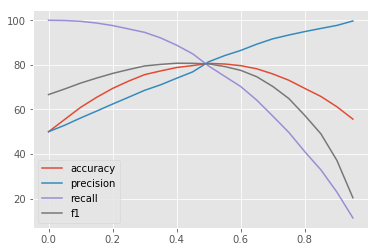

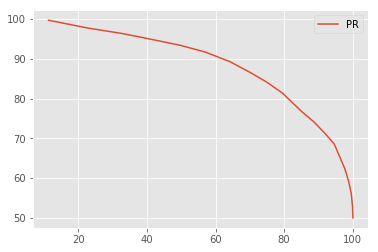

In [110]:
def confusion_matrix_prob(ans,prob,bound):
    tp,tn,fp,fn = 0,0,0,0
    for an,pd in zip(ans,prob):
        if an == 1 and pd >= bound:
            tp += 1
        elif an == -1 and pd < bound:
            tn += 1
        elif an > 0:
            fn += 1
        else:
            fp += 1
    return tp,tn,fp,fn

def acprecl_prob(outputs,prob,bound):
    tp,tn,fp,fn = confusion_matrix_prob(outputs,prob,bound)
    #tp,tn,fp,fn = confusion_matrix_prob(outputs,prob,0)
    accuracy = (tp + tn ) / ( tp + tn + fp + fn) * 100
    precision = tp / (tp + fp) * 100
    recall = tp / (tp + fn ) * 100
    f1 =  2 * tp /( 2 * tp + fp + fn) * 100
    return accuracy,precision,recall,f1


import matplotlib.pyplot as plt
figure = plt.figure()
plt.style.use("ggplot")
ax = figure.add_subplot(111)
acs = []
prs = []
res = []
f1s = []
prob_t = prob.transpose(1,0)[1]
bounds = [ i * 0.05 for i in range(0,20)]
for bound in bounds:
    print(bound)
    accuracy,precision,recall,f1 = acprecl_prob(outputs,prob_t,bound)
    acs.append(accuracy)
    prs.append(precision)
    res.append(recall)
    f1s.append(f1)

ax.plot(bounds,acs,label="accuracy")
ax.plot(bounds,prs,label="precision")
ax.plot(bounds,res,label="recall")
ax.plot(bounds,f1s,label="f1")
ax.legend()
figure = plt.figure()
bx = figure.add_subplot(111)
bx.plot(res,prs,label="PR")
bx.legend()
plt.show()

In [102]:
len(prob_t)
len(outputs)

10662

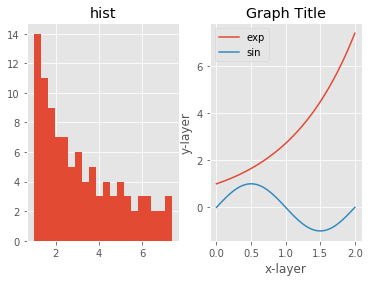

In [109]:
plt.style.use("ggplot")
fig = plt.figure()
ax = fig.add_subplot(122)
x = np.linspace(0,2.0,100)
y = np.exp(x)
z = np.sin(x * np.pi )

ax.plot(x,y,label="exp")
ax.set_xlabel("x-layer")
ax.set_ylabel("y-layer") 
ax.plot(x,z,label="sin")
ax.set_title("Graph Title")
ax.legend()
bx = fig.add_subplot(121)
bx.hist(y,label="sinhist",bins=20)
bx.set_title("hist")
plt.show()